# Descripción del data set Financial data of 4400+ public companies

✅ ¿Qué es?

Se trata de un conjunto de datos que contiene información financiera de más de 4 400 empresas públicas.  

Los datos fueron raspados (“scraped”) de Yahoo Finance, lo que incluye los estados financieros — el balance general (“balance sheet”), el estado de resultados (“income statement”), y el flujo de caja (“cash flow statement”).  

Incluye datos tanto anuales como trimestrales para un período reciente (aproximadamente los últimos 4 años) para cada empresa.  


# ¿Qué contiene exactamente?

Algunas de las características clave de la base de datos:

- Cada empresa viene identificada con su ticker o símbolo bursátil (o equivalente) y posiblemente con su nombre, industria, etc.
- Para cada empresa, los datos incluyen:
    - Estado de resultados: ingresos, beneficios, gastos, etc.
    - Balance general: activos, pasivos, capital contable, etc.
    - Flujo de caja: flujos operativos, de inversión, de financiación, etc.
- Los datos están organizados para que puedas ver la evolución por trimestre y por año, lo que permite análisis de tendencias.
- Se pueden usar variables financieras como predictors (por ejemplo: activos, pasivos, ingresos) y variables objetivo como beneficio, rentabilidad, crecimiento, etc.

# Paso 1 — Reconocer el dataset

1. Objetivo: investigar el dataset entregado en la asignación 2, revisar el nombre de cada columna y documentar qué representa cada una (tipo, unidad, periodicidad, observaciones).

2. Pasos recomendados:
    - Cargar el archivo entregado (por ejemplo: df = pd.read_csv(...)) y listar columnas: df.columns
    - Para cada columna: buscar su significado (glosario, documentación de la fuente, o inspección de valores).
    - Anotar tipo de dato, unidad (USD, porcentaje, entero), periodicidad (trimestral/anual) y cualquier observación (por ejemplo: calculada, acumulada, neta/bruta).
    - Generar la lista final con nombre y descripción clara y breve.

3. Ejemplo de Plantilla para la lista (reemplazar con las columnas reales del dataset):

- ticker: Identificador bursátil de la empresa (string). Ejemplo: "AAPL".
- fiscal_date: Fecha del periodo financiero (YYYY-MM-DD). Indica el cierre del trimestre/año.
- revenue: Ingresos netos durante el periodo (num, USD). Periodicidad: trimestral/anual.
- gross_profit: Beneficio bruto (num, USD). Definición: ingresos menos costo de ventas.
- operating_income: Resultado operativo (num, USD). Incluye gastos operativos.
- net_income: Beneficio neto después de impuestos (num, USD).


4. Resultado esperado:
    - Un listado documentado con cada columna del dataset y su descripción (puede entregarse como tabla o como lista de pares nombre→descripción).

In [1]:
import pandas as pd
import numpy as np

# Paso 1 — Reconocer el dataset
# Código paso a paso para cargar el CSV, inspeccionar columnas y generar una "documentación" automática
# Ruta del dataset (usar raw string para evitar problemas con backslashes)
path = r"C:\Users\Zyrmu\Downloads\platzi\Inteligencia Artificial\IA\IA_Mario_Morales\asignacion_2\balanceSheetHistory_annually.csv"

# 1) Imports

# 2) Cargar el dataset (baja memoria para evitar warnings en archivos grandes)
df = pd.read_csv(path, low_memory=False)

# 3) Información general rápida
print("Shape:", df.shape)
print("Columnas:", df.columns.tolist())
print("\nPrimeras 5 filas:")
display(df.head())
print("\nÚltimas 5 filas:")
display(df.tail())
print("\nResumen info():")
df.info()

# 4) Estadísticas y nulos por columna
null_counts = df.isna().sum()
pct_null = (null_counts / len(df) * 100).round(2)
n_unique = df.nunique(dropna=True)

print("\nNulos y unicidad (primeras 20 columnas para visual):")
display(pd.DataFrame({
    "dtype": df.dtypes,
    "n_unique": n_unique,
    "null_count": null_counts,
    "pct_null": pct_null
}).sort_values("pct_null").head(20))

# 5) Crear tabla de metadatos automática por columna
def sample_values(col_series, n=5):
    vals = col_series.dropna().unique()
    if len(vals) == 0:
        return ""
    try:
        return list(vals[:n])
    except Exception:
        return str(vals[:n])

def infer_unit(col_name, ser):
    name = col_name.lower()
    # heurísticas simples por nombre de columna
    if any(k in name for k in ["cash", "asset", "liab", "debt", "income", "revenue", "profit", "ebit", "net", "gross", "expense", "balance"]):
        return "USD (sugerido)"
    if any(k in name for k in ["rate", "ratio", "margin", "pct", "percentage", "%"]):
        return "porcentaje (%)"
    if "date" in name or "fiscal" in name or "year" in name:
        return "fecha / año"
    # si es numérico y valores típicos de monedas (enteros grandes), sugerir USD
    if pd.api.types.is_numeric_dtype(ser):
        median = ser.dropna().median() if ser.dropna().size>0 else 0
        if abs(median) > 10:  # heurística simple
            return "USD (posible)"
    return ""

metadata = []
for col in df.columns:
    ser = df[col]
    dtype = str(ser.dtype)
    uniq = int(n_unique.get(col, 0))
    pctnull = float(pct_null.get(col, 0.0))
    samples = sample_values(ser, n=5)
    unit_suggestion = infer_unit(col, ser)
    periodicity = "anual (archivo indica 'annually')"  # según nombre del archivo
    note = ""
    # detectar columnas con estructuras complejas (JSON-like) en strings
    if pd.api.types.is_object_dtype(ser):
        sample = ser.dropna().astype(str).head(20)
        # si alguna muestra contiene "{" o "[" asumimos estructura JSON-like
        if sample.str.contains(r"[\{\[]").any():
            note = "Puede contener JSON/estructura embebida. Revisar."
    # detectar columnas con fechas parseables
    if pd.api.types.is_object_dtype(ser):
        try:
            parsed = pd.to_datetime(ser.dropna().iloc[:10], errors="coerce")
            if parsed.notna().any():
                periodicity = "fecha detectada (posible cierre fiscal)"
                unit_suggestion = unit_suggestion or "fecha"
        except Exception:
            pass
    metadata.append({
        "column": col,
        "dtype": dtype,
        "n_unique": uniq,
        "pct_null": pctnull,
        "sample_values": samples,
        "suggested_unit": unit_suggestion,
        "periodicity": periodicity,
        "notes": note
    })

meta_df = pd.DataFrame(metadata)

# 6) Mostrar metadatos y guardarlos para revisión manual
display(meta_df)
meta_df.to_csv("metadata_balanceSheet_annually.csv", index=False)
print("Archivo de metadatos guardado como: metadata_balanceSheet_annually.csv")

# 7) Siguientes pasos recomendados (imprimir para guía)
print("""
Siguientes pasos manuales recomendados:
1) Revisar meta_df y completar/ajustar manualmente columnas: unidad (USD/%), periodicidad exacta, y notas.
2) Identificar columnas clave (ej. ticker/stock, endDate/fiscalDate, cash) y comprobar consistencia de nombres y tipos.
3) Convertir columnas de fecha (p. ej. endDate) con pd.to_datetime() y comprobar orden temporal.
4) Documentar cada columna final en formato: nombre → descripción, tipo, unidad, periodicidad, observaciones.
""")

Shape: (17511, 31)
Columnas: ['stock', 'endDate', 'accountsPayable', 'inventory', 'longTermDebt', 'netReceivables', 'netTangibleAssets', 'longTermInvestments', 'totalCurrentAssets', 'propertyPlantEquipment', 'otherStockholderEquity', 'deferredLongTermAssetCharges', 'totalCurrentLiabilities', 'cash', 'otherAssets', 'treasuryStock', 'goodWill', 'otherLiab', 'retainedEarnings', 'otherCurrentAssets', 'commonStock', 'totalAssets', 'otherCurrentLiab', 'deferredLongTermLiab', 'totalStockholderEquity', 'totalLiab', 'capitalSurplus', 'intangibleAssets', 'shortTermInvestments', 'shortLongTermDebt', 'minorityInterest']

Primeras 5 filas:


,stock,endDate,accountsPayable,inventory,longTermDebt,netReceivables,netTangibleAssets,longTermInvestments,totalCurrentAssets,propertyPlantEquipment,...,totalAssets,otherCurrentLiab,deferredLongTermLiab,totalStockholderEquity,totalLiab,capitalSurplus,intangibleAssets,shortTermInvestments,shortLongTermDebt,minorityInterest
0,IVC,2019-12-31,88003000.0,121184000.0,219464000.0,140013000.0,-91334000.0,85000.0,355877000.0,92183000.0,...,8.521260e+08,21634000.0,602000.0,308516000.0,543610000.0,312650000.0,26447000.0,NaN,NaN,NaN
1,IVC,2018-12-31,92469000.0,128644000.0,225733000.0,138476000.0,-48632000.0,90000.0,397410000.0,74306000.0,...,8.858550e+08,22750000.0,402000.0,359147000.0,526708000.0,297919000.0,26506000.0,NaN,NaN,NaN
2,IVC,2017-12-31,90566000.0,121933000.0,241405000.0,143464000.0,-8233000.0,103000.0,456914000.0,80016000.0,...,1.066033e+09,34119000.0,787000.0,423294000.0,642739000.0,290125000.0,30244000.0,NaN,NaN,NaN
3,IVC,2016-12-31,88236000.0,135644000.0,146088000.0,132707000.0,32762000.0,108000.0,409072000.0,75359000.0,...,9.037430e+08,33800000.0,793000.0,422387000.0,481356000.0,266151000.0,29023000.0,NaN,NaN,NaN
4,CSLT,2019-12-31,19596000.0,NaN,NaN,31397000.0,68911000.0,NaN,95470000.0,18762000.0,...,2.427840e+08,18768000.0,21429000.0,172874000.0,69910000.0,627899000.0,NaN,16411000.0,NaN,NaN



Últimas 5 filas:


,stock,endDate,accountsPayable,inventory,longTermDebt,netReceivables,netTangibleAssets,longTermInvestments,totalCurrentAssets,propertyPlantEquipment,...,totalAssets,otherCurrentLiab,deferredLongTermLiab,totalStockholderEquity,totalLiab,capitalSurplus,intangibleAssets,shortTermInvestments,shortLongTermDebt,minorityInterest
17506,INFI,2016-12-31,2413000.0,NaN,NaN,NaN,8.245400e+07,NaN,101660000.0,23424000.0,...,1.256550e+08,NaN,NaN,8.245400e+07,4.320100e+07,7.080960e+08,NaN,18004000.0,NaN,NaN
17507,IART,2019-12-31,113090000.0,316054000.0,1.341583e+09,283976000.0,-5.691350e+08,NaN,858168000.0,431934000.0,...,3.303240e+09,14673000.0,NaN,1.416736e+09,1.886504e+09,1.213620e+09,1.031591e+09,NaN,NaN,NaN
17508,IART,2018-12-31,76050000.0,280347000.0,1.341098e+09,265737000.0,-6.301750e+08,NaN,775082000.0,300112000.0,...,3.107887e+09,3764000.0,NaN,1.375796e+09,1.732091e+09,1.192601e+09,1.079496e+09,NaN,NaN,NaN
17509,IART,2017-12-31,93967000.0,296332000.0,1.782717e+09,251799000.0,-1.135226e+09,NaN,822146000.0,269251000.0,...,3.211257e+09,36485000.0,NaN,9.623060e+08,2.248951e+09,8.217580e+08,1.159627e+09,NaN,NaN,NaN
17510,IART,2016-12-31,29057000.0,217263000.0,6.650000e+08,148186000.0,-2.320790e+08,NaN,495170000.0,222369000.0,...,1.807954e+09,6978000.0,NaN,8.396670e+08,9.682870e+08,7.986520e+08,5.611750e+08,NaN,NaN,NaN



Resumen info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17511 entries, 0 to 17510
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   stock                         17511 non-null  object 
 1   endDate                       17511 non-null  object 
 2   accountsPayable               16415 non-null  float64
 3   inventory                     9640 non-null   float64
 4   longTermDebt                  11222 non-null  float64
 5   netReceivables                14544 non-null  float64
 6   netTangibleAssets             17351 non-null  float64
 7   longTermInvestments           7499 non-null   float64
 8   totalCurrentAssets            17331 non-null  float64
 9   propertyPlantEquipment        15768 non-null  float64
 10  otherStockholderEquity        12046 non-null  float64
 11  deferredLongTermAssetCharges  6055 non-null   float64
 12  totalCurrentLiabilities       17316 non-nul

,dtype,n_unique,null_count,pct_null
stock,object,4422,0,0.00
endDate,object,255,0,0.00
totalStockholderEquity,float64,17100,157,0.90
netTangibleAssets,float64,17089,160,0.91
totalAssets,float64,17179,172,0.98
totalCurrentAssets,float64,16999,180,1.03
totalLiab,float64,17087,185,1.06
totalCurrentLiabilities,float64,16830,195,1.11
cash,float64,15816,582,3.32
accountsPayable,float64,14819,1096,6.26


C:\Users\Zyrmu\AppData\Local\Temp\ipykernel_33140\1536021224.py:82: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(ser.dropna().iloc[:10], errors="coerce")


,column,dtype,n_unique,pct_null,sample_values,suggested_unit,periodicity,notes
0,stock,object,4422,0.00,"[IVC, CSLT, LPX, GDYN, ARA]",,anual (archivo indica 'annually'),
1,endDate,object,255,0.00,"[2019-12-31, 2018-12-31, 2017-12-31, 2016-12-3...",fecha / año,fecha detectada (posible cierre fiscal),
2,accountsPayable,float64,14819,6.26,"[88003000.0, 92469000.0, 90566000.0, 88236000....",USD (posible),anual (archivo indica 'annually'),
3,inventory,float64,8867,44.95,"[121184000.0, 128644000.0, 121933000.0, 135644...",USD (posible),anual (archivo indica 'annually'),
4,longTermDebt,float64,10746,35.91,"[219464000.0, 225733000.0, 241405000.0, 146088...",USD (sugerido),anual (archivo indica 'annually'),
5,netReceivables,float64,13691,16.94,"[140013000.0, 138476000.0, 143464000.0, 132707...",USD (sugerido),anual (archivo indica 'annually'),
6,netTangibleAssets,float64,17089,0.91,"[-91334000.0, -48632000.0, -8233000.0, 3276200...",USD (sugerido),anual (archivo indica 'annually'),
7,longTermInvestments,float64,6874,57.18,"[85000.0, 90000.0, 103000.0, 108000.0, 1000000...",USD (posible),anual (archivo indica 'annually'),
8,totalCurrentAssets,float64,16999,1.03,"[355877000.0, 397410000.0, 456914000.0, 409072...",USD (sugerido),anual (archivo indica 'annually'),
9,propertyPlantEquipment,float64,14905,9.95,"[92183000.0, 74306000.0, 80016000.0, 75359000....",USD (posible),anual (archivo indica 'annually'),


Archivo de metadatos guardado como: metadata_balanceSheet_annually.csv

Siguientes pasos manuales recomendados:
1) Revisar meta_df y completar/ajustar manualmente columnas: unidad (USD/%), periodicidad exacta, y notas.
2) Identificar columnas clave (ej. ticker/stock, endDate/fiscalDate, cash) y comprobar consistencia de nombres y tipos.
3) Convertir columnas de fecha (p. ej. endDate) con pd.to_datetime() y comprobar orden temporal.
4) Documentar cada columna final en formato: nombre → descripción, tipo, unidad, periodicidad, observaciones.



# Paso 2 — Seleccionar columnas relevantes

Después de haber cargado el dataset, elimina todas las columnas y quédate solo con: `stock`, `endDate` y `cash`.

- Verifica que los nombres y la capitalización de las columnas sean correctos antes de seleccionar.


In [2]:
import difflib

# Paso 2 — Seleccionar columnas relevantes: dejar solo 'stock', 'endDate' y 'cash'
desired = ['stock', 'endDate', 'cash']

# mapeo case-insensitive de columnas existentes
col_map = {c.lower(): c for c in df.columns}
missing = [d for d in desired if d.lower() not in col_map]

if missing:
    # sugerencias de nombres cercanos
    suggestions = {m: difflib.get_close_matches(m, df.columns, n=5) for m in missing}
    print(f"No se encontraron las columnas solicitadas: {missing}")
    print("Columnas disponibles (primeras 30):", list(df.columns[:30]))
    print("Sugerencias para columnas faltantes:", suggestions)
else:
    cols = [col_map[d.lower()] for d in desired]
    # sobrescribimos df con el subset solicitado (copia para evitar SettingWithCopyWarning)
    df = df[cols].copy()
    # convertir endDate a datetime (si no lo está)
    df['endDate'] = pd.to_datetime(df['endDate'], errors='coerce')
    # información resumida
    print("Columnas seleccionadas:", cols)
    print("Shape:", df.shape)
    print("\nConteo de nulos por columna:")
    print(df.isna().sum())
    display(df.head())

Columnas seleccionadas: ['stock', 'endDate', 'cash']
Shape: (17511, 3)

Conteo de nulos por columna:
stock        0
endDate      0
cash       582
dtype: int64


,stock,endDate,cash
0,IVC,2019-12-31,80063000.0
1,IVC,2018-12-31,116907000.0
2,IVC,2017-12-31,176528000.0
3,IVC,2016-12-31,124234000.0
4,CSLT,2019-12-31,43017000.0


# Paso 3 — Separar por empresas y elegir 3 para predecir su cantidad de dinero por fecha

- Objetivo: crear series temporales por empresa usando las columnas `stock`, `endDate` y `cash` y seleccionar 3 empresas para modelar y predecir `cash` por fecha.
- Pasos recomendados:
    - Verificar que las columnas `stock`, `endDate` y `cash` existen y están limpias (sin valores nulos o con imputación cuando sea necesario).
    - Ordenar el dataframe por `stock` y `endDate` (ascendente) para obtener la serie temporal de cada empresa.
    - Agrupar por `stock` y crear un subset por empresa.
    - Elegir 3 empresas con suficientes observaciones (p. ej. mayor número de fechas disponibles o relevancia del negocio).
    - Para cada empresa seleccionada, preparar los datos de entrenamiento/validación (features temporales, ventanas, lag, etc.) y definir la variable objetivo `cash` por `endDate`.

In [3]:
from datetime import date

# Paso 3 — Separar por empresas y preparar series temporales (código)
# Usa el df ya existente con columnas: 'stock', 'endDate', 'cash'

required = ['stock', 'endDate', 'cash']
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas requeridas en df: {missing}")

# 1) Verificar nulos y limpieza mínima
print("Nulos por columna (subset):")
print(df[required].isna().sum())

# eliminar filas sin stock o endDate (no tienen sentido para series)
df = df.dropna(subset=['stock', 'endDate']).copy()

# 2) Ordenar por stock y endDate (ascendente)
df = df.sort_values(['stock', 'endDate'], ascending=[True, True]).reset_index(drop=True)

# 3) Contar observaciones por empresa y elegir 3 con más datos
counts = df.groupby('stock').size().sort_values(ascending=False)
min_obs = 4  # criterio mínimo razonable para series anuales; ajustar según necesidad
top3 = counts[counts >= min_obs].head(3)
if len(top3) < 3:
    # fallback: tomar top 3 aunque no cumplan min_obs
    top3 = counts.head(3)
selected_stocks = top3.index.tolist()
print("\nEmpresas seleccionadas (stock -> n_obs):")
print(top3)

# 4) Crear diccionario con series por empresa y preparar features temporales simples
#    (lags de cash, ventana móvil y variables temporales)

per_stock = {}
lags = [1, 2]  # rezagos a crear
rol_window = 2

for s in selected_stocks:
    ts = df[df['stock'] == s].sort_values('endDate').reset_index(drop=True).copy()
    # Feature temporal: índice t (0,1,2...) y año
    ts['t'] = np.arange(len(ts))
    ts['year'] = ts['endDate'].dt.year

    # Rezagos de cash
    for l in lags:
        ts[f'cash_lag_{l}'] = ts['cash'].shift(l)

    # Media móvil simple
    ts[f'cash_roll_mean_{rol_window}'] = ts['cash'].rolling(window=rol_window, min_periods=1).mean().shift(1)

    # Mantener filas válidas para modelado (eliminar aquellas sin objetivo o sin rezagos si se requieren)
    model_df = ts.dropna(subset=['cash'])  # requerimos y presente
    # si se usan rezagos, eliminar filas con NaNs en los rezagos
    model_df = model_df.dropna(subset=[f'cash_lag_{l}' for l in lags] + [f'cash_roll_mean_{rol_window}'], how='any')

    X_cols = [f'cash_lag_{l}' for l in lags] + [f'cash_roll_mean_{rol_window}', 't', 'year']
    X = model_df[X_cols].copy()
    y = model_df['cash'].copy()

    per_stock[s] = {
        'raw_ts': ts,           # serie completa ordenada
        'model_df': model_df,   # df listo para modelado (sin NaNs en features seleccionadas)
        'X': X,
        'y': y,
        'X_cols': X_cols
    }

    print(f"\nStock: {s} | total rows: {len(ts)} | rows utilisables para modelado: {len(model_df)}")
    if len(model_df) < 2:
        print(f"  -> Atención: pocos datos útiles para modelado (<{2}). Considerar cambiar criterios o agregar más features/imputación.")

# Resultado: variables 'selected_stocks' (lista de 3 tickers) y 'per_stock' (dict con datos por empresa)
print("\nSelected stocks:", selected_stocks)

Nulos por columna (subset):
stock        0
endDate      0
cash       582
dtype: int64

Empresas seleccionadas (stock -> n_obs):
stock
ZYXI    4
A       4
AA      4
dtype: int64

Stock: ZYXI | total rows: 4 | rows utilisables para modelado: 2

Stock: A | total rows: 4 | rows utilisables para modelado: 2

Stock: AA | total rows: 4 | rows utilisables para modelado: 2

Selected stocks: ['ZYXI', 'A', 'AA']


# Paso 4 — Grafique tiempo vs dinero de las 3 empresas en 3 gráficas diferentes

Objetivo: visualizar la serie temporal de `cash` frente a `endDate` para cada una de las 3 empresas seleccionadas, colocando cada empresa en una gráfica independiente.

Pasos recomendados:
- Asegurarse de tener el DataFrame con las columnas `stock`, `endDate` y `cash` y ordenado por `stock` y `endDate` ascendente.
- Convertir `endDate` a tipo fecha: `df['endDate'] = pd.to_datetime(df['endDate'])`.
- Seleccionar las 3 empresas elegidas: p. ej. `stocks = ['AAA','BBB','CCC']` y crear un subset por cada `stock`.
- Para cada empresa, graficar `endDate` en el eje x y `cash` en el eje y en una figura separada.
- Configurar títulos, etiquetas de ejes y formato de fechas (rotar etiquetas si es necesario). Añadir grid y leyenda si procede.
- Opcional: usar subplots (3 filas x 1 columna) para mostrar las 3 gráficas en la misma figura o generar 3 figuras individuales según preferencia.
- Guardar las figuras si es necesario: `plt.savefig('cash_stock_AAA.png', bbox_inches='tight')`.

Ejemplo de librerías a usar: matplotlib, seaborn o plotly para interactividad.

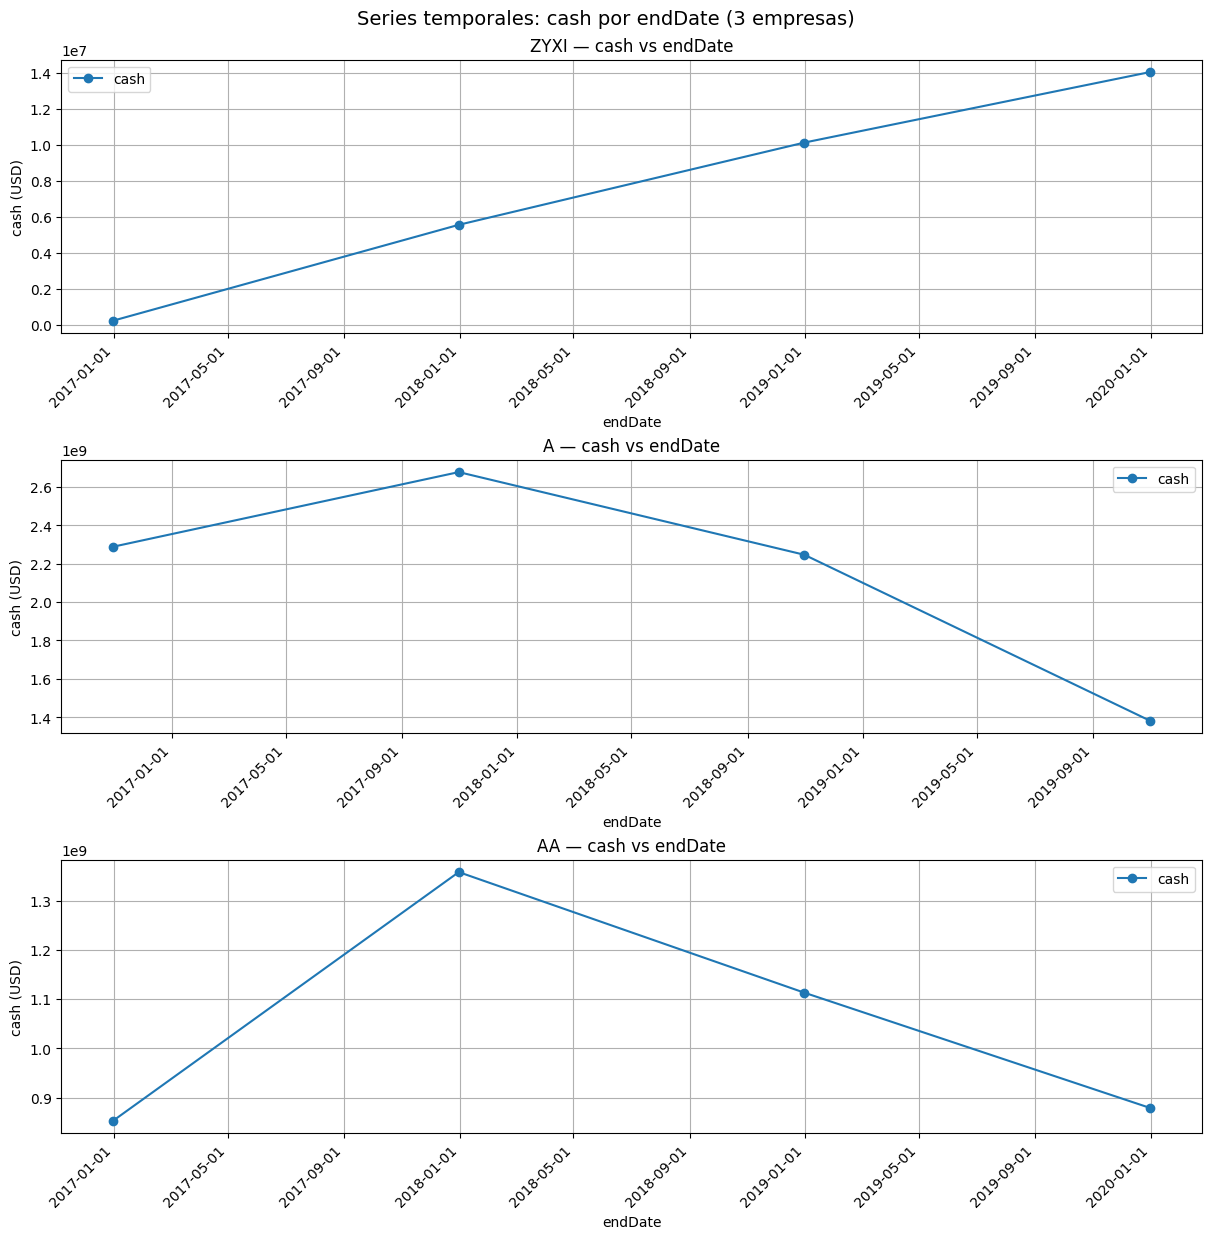

In [5]:
from matplotlib.dates import AutoDateLocator, DateFormatter

# Paso 4 — Graficar time vs cash para las 3 empresas seleccionadas
import matplotlib.pyplot as plt

stocks = selected_stocks  # ['ZYXI', 'A', 'AA']
n = len(stocks)
if n == 0:
    raise ValueError("No hay stocks seleccionados en 'selected_stocks'.")

fig, axes = plt.subplots(n, 1, figsize=(12, 4 * n), constrained_layout=True)
if n == 1:
    axes = [axes]

for ax, s in zip(axes, stocks):
    ts = per_stock.get(s, {}).get('raw_ts')
    if ts is None or ts.empty:
        ax.text(0.5, 0.5, f"No hay datos para {s}", ha='center', va='center')
        ax.set_title(s)
        continue

    # Asegurar orden y eliminar filas sin cash
    ts_plot = ts.sort_values('endDate').dropna(subset=['cash'])
    if ts_plot.empty:
        ax.text(0.5, 0.5, f"No hay valores de 'cash' para {s}", ha='center', va='center')
        ax.set_title(s)
        continue

    ax.plot(ts_plot['endDate'], ts_plot['cash'], marker='o', linestyle='-', label='cash')
    ax.set_title(f'{s} — cash vs endDate')
    ax.set_xlabel('endDate')
    ax.set_ylabel('cash (USD)')
    ax.grid(True)
    ax.legend()

    # Formato de fechas
    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    for lbl in ax.get_xticklabels():
        lbl.set_rotation(45)
        lbl.set_ha('right')

plt.suptitle('Series temporales: cash por endDate (3 empresas)', y=1.02, fontsize=14)
plt.show()

# Opcional: guardar cada figura individualmente (descomentar si se desea)
# for s in stocks:
#     ts_plot = per_stock[s]['raw_ts'].sort_values('endDate').dropna(subset=['cash'])
#     if ts_plot.empty: continue
#     plt.figure(figsize=(10,4))
#     plt.plot(ts_plot['endDate'], ts_plot['cash'], marker='o')
#     plt.title(f'{s} — cash vs endDate')
#     plt.xlabel('endDate'); plt.ylabel('cash (USD)'); plt.grid(True)
#     plt.gca().xaxis.set_major_locator(AutoDateLocator())
#     plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
#     plt.xticks(rotation=45, ha='right')
#     plt.tight_layout()
#     plt.savefig(f'cash_{s}.png', bbox_inches='tight')
#     plt.close()

# Paso 5 — División 80/20 (entrenamiento / prueba)

Objetivo: separar los datos en 80% para entrenamiento y 20% para prueba respetando la estructura temporal por empresa (sin hacer shuffle).

Recomendaciones:
- Asegúrate de tener las columnas `stock`, `endDate` y `cash` y que el dataframe esté ordenado por `stock` y `endDate` (ascendente).
- Para series temporales por empresa, usa una división basada en tiempo: los primeros 80% de observaciones de cada `stock` → train; los últimos 20% → test.



In [6]:
from math import floor

# Paso 5 — División 80/20 temporal por empresa (train/test) — cell nuevo
# Usa variables ya existentes: per_stock (dict con 'model_df' y 'X_cols'), selected_stocks


if 'per_stock' not in globals() or not isinstance(per_stock, dict):
    raise RuntimeError("No se encontró 'per_stock' en el entorno. Ejecuta los pasos previos primero.")

for s in selected_stocks:
    data = per_stock.get(s)
    if data is None:
        print(f"[SKIP] No hay información para {s}")
        continue

    model_df = data.get('model_df')
    if model_df is None or model_df.empty:
        print(f"[SKIP] model_df vacío para {s}")
        continue

    # Asegurar orden temporal ascendente
    model_df = model_df.sort_values('endDate').reset_index(drop=True).copy()

    n_rows = len(model_df)
    # índice de corte 80% (asegurando al menos 1 en test y 1 en train si es posible)
    cut = int(floor(n_rows * 0.8))
    if cut < 1:
        cut = 1
    if cut >= n_rows:
        cut = n_rows - 1 if n_rows > 1 else 0

    train_df = model_df.iloc[:cut].copy()
    test_df = model_df.iloc[cut:].copy()

    X_cols = data.get('X_cols')
    if not X_cols:
        # fallback: usar todas las columnas menos las no-features
        X_cols = [c for c in model_df.columns if c not in ('stock', 'endDate', 'cash')]

    X_train = train_df[X_cols].copy() if not train_df.empty else train_df[X_cols]
    y_train = train_df['cash'].copy() if 'cash' in train_df.columns else train_df.iloc[:, 0]
    X_test = test_df[X_cols].copy() if not test_df.empty else test_df[X_cols]
    y_test = test_df['cash'].copy() if 'cash' in test_df.columns else test_df.iloc[:, 0]

    # Guardar splits dentro del diccionario per_stock
    per_stock[s].update({
        'train_df': train_df,
        'test_df': test_df,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'split_index': cut
    })

    # Imprimir resumen conciso
    tr_range = (train_df['endDate'].min(), train_df['endDate'].max()) if not train_df.empty else (None, None)
    te_range = (test_df['endDate'].min(), test_df['endDate'].max()) if not test_df.empty else (None, None)
    print(f"{s}: total={n_rows} -> train={len(train_df)} | test={len(test_df)} | cut={cut}")
    print(f"    train dates: {tr_range[0]} -> {tr_range[1]}")
    print(f"    test  dates: {te_range[0]} -> {te_range[1]}")

# Resultado: per_stock ahora contiene X_train, X_test, y_train, y_test por empresa

ZYXI: total=2 -> train=1 | test=1 | cut=1
    train dates: 2018-12-31 00:00:00 -> 2018-12-31 00:00:00
    test  dates: 2019-12-31 00:00:00 -> 2019-12-31 00:00:00
A: total=2 -> train=1 | test=1 | cut=1
    train dates: 2018-10-31 00:00:00 -> 2018-10-31 00:00:00
    test  dates: 2019-10-31 00:00:00 -> 2019-10-31 00:00:00
AA: total=2 -> train=1 | test=1 | cut=1
    train dates: 2018-12-31 00:00:00 -> 2018-12-31 00:00:00
    test  dates: 2019-12-31 00:00:00 -> 2019-12-31 00:00:00


# Paso 6 — crea y entrena el modelo de regresión lineal para predecir `cash` por empresa

Objetivo: entrenar un modelo de regresión lineal por cada `stock` usando la serie temporal (respetando orden temporal) y evaluar en el 20% final.

Pasos recomendados:
- Preprocesamiento
    - Definir variables para el entrenamiento: y = `cash` (variable objetivo). `data` → X (conjunto de características a usar para predecir `cash`, p. ej. rezagos de `cash`, indicadores temporales, variables exógenas). Usar X e y en el entrenamiento: `model.fit(X_train, y_train)`.
    - Asegurar `endDate` como datetime y ordenar por `stock`, `endDate`.  - Asegurar `endDate` como datetime y ordenar por `stock`, `endDate`.



In [8]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Reentrenar modelos evitando warnings comunes (SettingWithCopyWarning, UndefinedMetricWarning)

# Validaciones previas
if 'per_stock' not in globals() or not isinstance(per_stock, dict):
    raise RuntimeError("No se encontró 'per_stock'. Ejecuta los pasos previos.")

for s in selected_stocks:
    info = per_stock.get(s)
    if info is None:
        print(f"[SKIP] No hay datos para {s}")
        continue

    X_train = info.get('X_train')
    y_train = info.get('y_train')
    X_test = info.get('X_test')
    y_test = info.get('y_test')

    # Validaciones básicas
    if X_train is None or y_train is None or X_train.shape[0] == 0:
        print(f"[SKIP] Sin datos de entrenamiento para {s}")
        continue
    if X_test is None or y_test is None or X_test.shape[0] == 0:
        print(f"[SKIP] Sin datos de prueba para {s}")
        continue

    # Convertir a arrays numéricos de forma explícita (evita warnings por tipos)
    try:
        X_tr = np.asarray(X_train.values, dtype=float)
        y_tr = np.asarray(y_train.values, dtype=float).ravel()
        X_te = np.asarray(X_test.values, dtype=float)
        y_te = np.asarray(y_test.values, dtype=float).ravel()
    except Exception as e:
        print(f"[ERROR] Conversión a numpy falló para {s}: {e}")
        continue

    # Entrenar modelo (reutilizamos sklearn.linear_model.LinearRegression ya disponible)
    model = LinearRegression()
    try:
        model.fit(X_tr, y_tr)
    except Exception as e:
        print(f"[ERROR] Entrenamiento falló para {s}: {e}")
        continue

    # Predecir sobre test
    try:
        y_pred = model.predict(X_te)
    except Exception as e:
        print(f"[ERROR] Predicción falló para {s}: {e}")
        continue

    # Guardar predicciones alineadas con el índice original del test_df
    test_idx = info.get('test_df').index if info.get('test_df') is not None else None
    y_pred_series = pd.Series(y_pred, index=test_idx, name='y_pred')

    # Métricas: evitar llamar r2_score con <2 muestras (provoca UndefinedMetricWarning y retorna NaN)
    mse = float(mean_squared_error(y_te, y_pred))
    rmse = float(np.sqrt(mse))
    r2 = float(r2_score(y_te, y_pred)) if y_te.shape[0] >= 2 else np.nan

    # Actualizar diccionario per_stock de forma segura
    per_stock[s].update({
        'model': model,
        'y_pred': y_pred_series,
        'metrics': {'mse': mse, 'rmse': rmse, 'r2': r2}
    })

    # Resumen conciso
    print(f"{s}: train_rows={X_tr.shape[0]} | test_rows={X_te.shape[0]} -> RMSE={rmse:.2f} | R2={'nan' if np.isnan(r2) else f'{r2:.4f}'}")

ZYXI: train_rows=1 | test_rows=1 -> RMSE=3912000.00 | R2=nan
A: train_rows=1 | test_rows=1 -> RMSE=865000000.00 | R2=nan
AA: train_rows=1 | test_rows=1 -> RMSE=234000000.00 | R2=nan


# Paso 7 — Verifica tu modelo de regresión lineal: grafica real vs predicho para las 3 empresas

- Objetivo: comparar visualmente los valores reales de `cash` del conjunto de prueba con los valores predichos por el modelo para cada una de las 3 empresas seleccionadas.
- Requisitos: tener `endDate` como datetime, el conjunto test por cada `stock`, y las predicciones (`y_pred`) para cada test.
- Pasos recomendados:
    - Para cada empresa (stock):
        - Extraer test: filas finales (20%) ordenadas por `endDate`.
        - Obtener predicciones usando el modelo entrenado: `y_pred = model.predict(X_test)`.
        - Crear una gráfica con `endDate` en el eje x y ambos: `cash` real (línea/points) y `cash` predicho (línea punteada) en el eje y.
        - Añadir título con el ticker, leyenda, etiquetas de ejes y grid. Formatear fechas y rotar etiquetas si hace falta.
    - Opcional: mostrar las 3 series en subplots (3 filas x 1 columna) para facilitar comparación.
    - Calcular y mostrar métricas de error por empresa (MAE, RMSE, R2) bajo cada gráfico o en una tabla resumen.
- Resultado esperado: tres gráficas (una por empresa) mostrando real vs predicho y una tabla o texto con las métricas de evaluación.

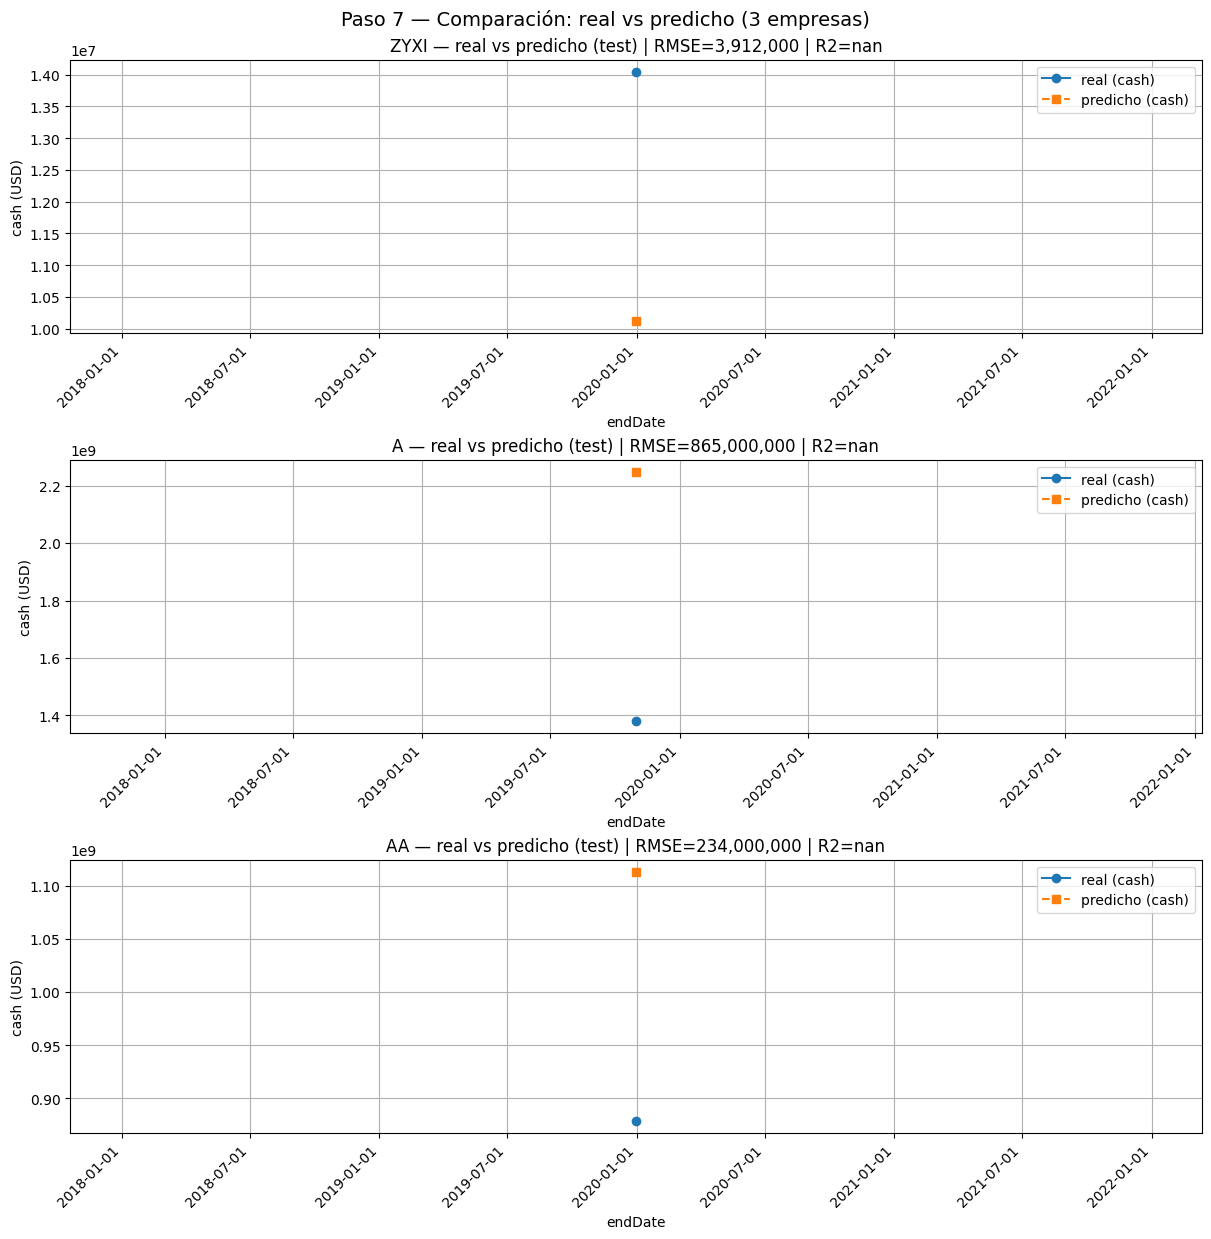


Resumen de métricas por empresa (MSE, RMSE, MAE, R2):
stock               MSE           RMSE          MAE       R2
ZYXI     15303744000000.00     3912000.00   3912000.00      nan
A        748225000000000000.00   865000000.00 865000000.00      nan
AA       54756000000000000.00   234000000.00 234000000.00      nan

Conclusión (automática):
- ZYXI: R2 no disponible (pocos puntos en test). RMSE=3,912,000 (error absoluto aproximado).
- A: R2 no disponible (pocos puntos en test). RMSE=865,000,000 (error absoluto aproximado).
- AA: R2 no disponible (pocos puntos en test). RMSE=234,000,000 (error absoluto aproximado).


In [9]:
from matplotlib.dates import AutoDateLocator, DateFormatter

# Paso 7 — Verificación paso a paso: real vs predicho por empresa (3 gráficas + métricas)
import matplotlib.pyplot as plt

results = []  # recolecta métricas para tabla resumen

stocks = selected_stocks  # usa la variable ya existente
n = len(stocks)
if n == 0:
    raise RuntimeError("No hay stocks en 'selected_stocks' para evaluar.")

fig, axes = plt.subplots(n, 1, figsize=(12, 4 * n), constrained_layout=True)
if n == 1:
    axes = [axes]

for ax, s in zip(axes, stocks):
    info = per_stock.get(s, {})
    test_df = info.get('test_df')
    y_pred_ser = info.get('y_pred')            # Serie alineada al índice de test_df (si existe)
    model = info.get('model')

    # Validaciones básicas
    if test_df is None or test_df.empty:
        ax.text(0.5, 0.5, f"No hay conjunto de prueba para {s}", ha='center', va='center')
        ax.set_title(s)
        results.append((s, None, None, None, None))
        continue
    if y_pred_ser is None or y_pred_ser.empty:
        ax.text(0.5, 0.5, f"No hay predicciones para {s}", ha='center', va='center')
        ax.set_title(s)
        results.append((s, None, None, None, None))
        continue

    # Alineación: unir test_df con las predicciones por índice
    df_plot = test_df.copy()
    # aseguramos que la predicción esté en la misma forma (Series con índice)
    y_pred_aligned = y_pred_ser.reindex(df_plot.index)
    df_plot = df_plot.assign(y_pred=y_pred_aligned.values)

    # Extraer valores numéricos para métricas
    y_true = df_plot['cash'].astype(float).values
    y_pred = df_plot['y_pred'].astype(float).values

    # Métricas (evitar r2 con una sola muestra)
    mse_local = float(np.mean((y_true - y_pred) ** 2))
    rmse_local = float(np.sqrt(mse_local))
    mae_local = float(np.mean(np.abs(y_true - y_pred)))
    r2_local = float(r2_score(y_true, y_pred)) if y_true.shape[0] >= 2 else float('nan')

    results.append((s, mse_local, rmse_local, mae_local, r2_local))

    # Gráfica: real vs predicho
    ax.plot(df_plot['endDate'], df_plot['cash'], marker='o', linestyle='-', label='real (cash)')
    ax.plot(df_plot['endDate'], df_plot['y_pred'], marker='s', linestyle='--', label='predicho (cash)')
    ax.set_title(f"{s} — real vs predicho (test) | RMSE={rmse_local:,.0f} | R2={'nan' if np.isnan(r2_local) else f'{r2_local:.3f}'}")
    ax.set_xlabel('endDate')
    ax.set_ylabel('cash (USD)')
    ax.grid(True)
    ax.legend()

    # Formato de fechas
    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    for lbl in ax.get_xticklabels():
        lbl.set_rotation(45)
        lbl.set_ha('right')

plt.suptitle('Paso 7 — Comparación: real vs predicho (3 empresas)', y=1.02, fontsize=14)
plt.show()

# Imprimir tabla resumen de métricas
print("\nResumen de métricas por empresa (MSE, RMSE, MAE, R2):")
print("{:<8} {:>14} {:>14} {:>12} {:>8}".format("stock", "MSE", "RMSE", "MAE", "R2"))
for s, mse_local, rmse_local, mae_local, r2_local in results:
    if mse_local is None:
        print(f"{s:<8} {'-':>14} {'-':>14} {'-':>12} {'-':>8}")
    else:
        print(f"{s:<8} {mse_local:14.2f} {rmse_local:14.2f} {mae_local:12.2f} {('nan' if np.isnan(r2_local) else f'{r2_local:.4f}'):>8}")

# Conclusión corta automática por lo observado
print("\nConclusión (automática):")
for s, mse_local, rmse_local, mae_local, r2_local in results:
    if mse_local is None:
        print(f"- {s}: falta test/predicción.")
        continue
    if np.isnan(r2_local):
        print(f"- {s}: R2 no disponible (pocos puntos en test). RMSE={rmse_local:,.0f} (error absoluto aproximado).")
    else:
        print(f"- {s}: RMSE={rmse_local:,.0f}, R2={r2_local:.3f}. Evaluar si RMSE es aceptable respecto a la escala de 'cash'.")

# Paso 8 — Verificación de modelos (MSE, RMSE, R2)

Instrucciones breves:
- Asegúrese de tener para cada empresa: y_test (valores reales) y y_pred (predicciones).
- Calcular métricas con sklearn: mean_squared_error(y_test, y_pred), RMSE = sqrt(MSE), r2_score(y_test, y_pred).
- Presentar los resultados en una tabla por empresa y añadir una conclusión corta.

Empresa 1 (ticker: AAA)
| Métrica | Valor |
|---|---|
| MSE |  |
| RMSE |  |
| R2 |  |

Empresa 2 (ticker: BBB)
| Métrica | Valor |
|---|---|
| MSE |  |
| RMSE |  |
| R2 |  |

Empresa 3 (ticker: CCC)
| Métrica | Valor |
|---|---|
| MSE |  |
| RMSE |  |
| R2 |  |

Pequeña conclusión:
- Comparar RMSE/MSE absolutos para evaluar error en unidades de `cash`; RMSE más bajo = mejor precisión.
- R2 indica proporción de varianza explicada (cercano a 1 → buen ajuste; cercano a 0 o negativo → mal ajuste).
- Si alguno de los modelos muestra RMSE alto o R2 bajo, considerar: más features (rezagos, variables temporales), regularización, transformación de la serie o modelos no lineales.

In [12]:
# Paso 8 (celda nueva) — Cálculo y visualización bonita de métricas y tablas por empresa
# Usa variables ya presentes en el notebook: per_stock, selected_stocks, pd, np, mean_squared_error, r2_score, display

rows = []
details = {}

for s in selected_stocks:
    info = per_stock.get(s, {})
    test_df = info.get('test_df')
    y_pred_ser = info.get('y_pred')

    if test_df is None or test_df.empty or y_pred_ser is None:
        rows.append((s, 0, np.nan, np.nan, np.nan, np.nan))
        details[s] = None
        continue

    # Alinear predicciones y verdaderos
    try:
        y_pred_aligned = y_pred_ser.reindex(test_df.index).astype(float).values
    except Exception:
        y_pred_aligned = np.asarray(y_pred_ser, dtype=float).ravel()

    y_true = np.asarray(test_df['cash'].astype(float).values).ravel()
    m = min(len(y_true), len(y_pred_aligned))
    if m == 0:
        rows.append((s, 0, np.nan, np.nan, np.nan, np.nan))
        details[s] = None
        continue

    y_true = y_true[:m]
    y_pred_aligned = y_pred_aligned[:m]

    mse_val = float(mean_squared_error(y_true, y_pred_aligned))
    rmse_val = float(np.sqrt(mse_val))
    mae_val = float(np.mean(np.abs(y_true - y_pred_aligned)))
    r2_val = float(r2_score(y_true, y_pred_aligned)) if y_true.shape[0] >= 2 else float('nan')

    rows.append((s, int(m), mse_val, rmse_val, mae_val, r2_val))

    # Tabla detalle por empresa: endDate, real, predicho, error absoluto, error %
    det = test_df[['endDate', 'cash']].copy().reset_index(drop=True)
    det['predicted_cash'] = y_pred_aligned
    det['error_abs'] = (det['cash'] - det['predicted_cash']).abs()
    det['error_pct'] = np.where(det['cash'] != 0, (det['error_abs'] / det['cash']) * 100.0, np.nan)
    details[s] = det

# DataFrame resumen
summary_df = pd.DataFrame(rows, columns=['stock', 'n_test', 'MSE', 'RMSE', 'MAE', 'R2']).set_index('stock')

# Formateo y estilo para buena visualización
fmt = {
    'n_test': '{:.0f}',
    'MSE': '{:,.0f}',
    'RMSE': '{:,.0f}',
    'MAE': '{:,.0f}',
    'R2': '{:.4f}'
}
table_styles = [
    {'selector': 'th', 'props': [('border', '1px solid #444'), ('background-color', '#f0f0f0')]},
    {'selector': 'td', 'props': [('border', '1px solid #ddd')]},
    {'selector': 'table', 'props': [('border-collapse', 'separate'), ('border-spacing', '0'), ('width','80%')]}
]

# Mostrar resumen estilado
display(summary_df.style.format(fmt).set_table_styles(table_styles).set_caption("Resumen de métricas por empresa (Paso 8)"))

# Mostrar tablas detalle por empresa (si existen) con estilo
for s in selected_stocks:
    det = details.get(s)
    if det is None or det.empty:
        display(pd.DataFrame({'info':[f"No hay test/predicciones para {s}"]}).style.set_table_styles(table_styles).set_caption(f"Detalle: {s}"))
        continue
    det_display = det.copy()
    # Formatos legibles
    det_display['endDate'] = pd.to_datetime(det_display['endDate']).dt.date
    det_display[['cash','predicted_cash','error_abs']] = det_display[['cash','predicted_cash','error_abs']].applymap(lambda x: f"{x:,.0f}")
    det_display['error_pct'] = det_display['error_pct'].map(lambda x: f"{x:.2f}%" if not pd.isna(x) else "nan")
    display(det_display.style.set_table_styles(table_styles).set_caption(f"Detalle: valores reales vs predichos — {s}"))

# Resumen textual corto
print("Conclusión breve:")
for stock, row in summary_df.iterrows():
    mse_val, rmse_val, r2_val = row['MSE'], row['RMSE'], row['R2']
    n_test = int(row['n_test'])
    if n_test == 0 or np.isnan(rmse_val):
        print(f"- {stock}: faltan datos de test/predicción.")
        continue
    perf = "bajo ajuste"
    if not np.isnan(r2_val):
        if r2_val >= 0.7:
            perf = "buen ajuste relativo"
        elif r2_val >= 0.3:
            perf = "ajuste moderado"
        else:
            perf = "bajo ajuste"
    print(f"- {stock}: n_test={n_test}, RMSE={rmse_val:,.0f}. R2={'nan' if np.isnan(r2_val) else f'{r2_val:.3f}'} → {perf}.")

,n_test,MSE,RMSE,MAE,R2
stock,,,,,
ZYXI,1,"15,303,744,000,000","3,912,000","3,912,000",nan
A,1,"748,225,000,000,000,000","865,000,000","865,000,000",nan
AA,1,"54,756,000,000,000,000","234,000,000","234,000,000",nan


C:\Users\Zyrmu\AppData\Local\Temp\ipykernel_33140\1474665164.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  det_display[['cash','predicted_cash','error_abs']] = det_display[['cash','predicted_cash','error_abs']].applymap(lambda x: f"{x:,.0f}")


,endDate,cash,predicted_cash,error_abs,error_pct
0,2019-12-31,"14,040,000","10,128,000","3,912,000",27.86%


C:\Users\Zyrmu\AppData\Local\Temp\ipykernel_33140\1474665164.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  det_display[['cash','predicted_cash','error_abs']] = det_display[['cash','predicted_cash','error_abs']].applymap(lambda x: f"{x:,.0f}")


,endDate,cash,predicted_cash,error_abs,error_pct
0,2019-10-31,"1,382,000,000","2,247,000,000","865,000,000",62.59%


C:\Users\Zyrmu\AppData\Local\Temp\ipykernel_33140\1474665164.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  det_display[['cash','predicted_cash','error_abs']] = det_display[['cash','predicted_cash','error_abs']].applymap(lambda x: f"{x:,.0f}")


,endDate,cash,predicted_cash,error_abs,error_pct
0,2019-12-31,"879,000,000","1,113,000,000","234,000,000",26.62%


Conclusión breve:
- ZYXI: n_test=1, RMSE=3,912,000. R2=nan → bajo ajuste.
- A: n_test=1, RMSE=865,000,000. R2=nan → bajo ajuste.
- AA: n_test=1, RMSE=234,000,000. R2=nan → bajo ajuste.


## Preguntas de Analisis 

1. ¿Qué variables (features) usaste para predecir `cash` y por qué crees que son relevantes?
Features usadas: cash_lag_1, cash_lag_2, cash_roll_mean_2, t, year.

Por qué son relevantes:
- cash_lag_1, cash_lag_2: rezagos de cash (valores anteriores). Capturan dependencia temporal y momentum de la serie.
- cash_roll_mean_2: media móvil de 2 periodos. Suaviza ruido y refleja la tendencia local reciente.
- t: índice temporal (0,1,2,...). Permite capturar una tendencia lineal o crecimiento/declive general.
- year: año del periodo. Permite modelar efectos anuales o cambios estructurales entre años.


2. ¿Cómo realizaste la división temporal 80/20 por empresa y por qué es importante no barajar (shuffle) los datos en series temporales?

Cómo lo hice:

Para cada empresa (cada ticker) ordené sus observaciones por fecha ascendente y conté cuántas filas tenía la serie.
Calculé el punto de corte como el 80% del total (usando floor) y tomé las primeras observaciones hasta ese corte como conjunto de entrenamiento y las restantes como conjunto de prueba.
Ajusté el corte para asegurar al menos una muestra en train y otra en test cuando la serie era muy corta.
Por qué no barajar (shuffle) los datos:

Barajar rompe la dependencia temporal y permite que el modelo vea información del “futuro” durante el entrenamiento, lo que provoca leak y evaluación optimista.
Mantener el orden temporal reproduce el escenario real de predicción (usar datos pasados para predecir el futuro) y da métricas más honestas.
La división temporal protege la validez del test: las métricas reflejan rendimiento en datos que ocurren después de los usados para entrenar.

3. ¿Cuál es la diferencia entre MSE y RMSE y qué nos dice cada métrica sobre la precisión de las predicciones?
MSE (Error Cuadrático Medio): es el promedio de los cuadrados de los errores (predicho − real).
 Penaliza fuertemente los errores grandes por el término cuadrado, por eso es útil cuando queremos castigar outliers; su unidad es el cuadrado de la variable objetivo (p. ej. USD²), lo que hace menos intuitiva su interpretación directa.

RMSE (Raíz del MSE): es la raíz cuadrada del MSE. Devuelve el error en la misma unidad que la variable objetivo (p. ej. USD), por lo que es más fácil de interpretar y comparar con la magnitud típica de los valores reales.

Qué nos dicen sobre precisión:

Ambos miden cuánto, en promedio, se alejan las predicciones de los valores reales; valores más bajos ⇒ mejor precisión.
MSE destaca y amplifica errores grandes; RMSE ofrece una medida interpretable en la misma escala que la variable y es la métrica más usada para comunicar error.
Ambos son sensibles a outliers; si hay muchos outliers conviene revisar medianas o MAE como complementos.

4. ¿Qué interpreta el valor de R² en este problema (predicción de `cash`) y qué limitaciones tiene su interpretación en series temporales?
R² (coeficiente de determinación) mide la proporción de la varianza de los valores reales que el modelo explica respecto a usar la media como predictor. Valores cerca de 1 indican que el modelo explica gran parte de la variabilidad; valores cercanos a 0 indican que no mejora la media; valores negativos significan que el modelo es peor que predecir siempre la media.

En el contexto de predecir cash:

Un R² alto sugiere que el modelo captura la mayor parte de la variación histórica de cash en el conjunto evaluado.
No garantiza que los errores absolutos sean pequeños (para eso conviene RMSE/MAE) ni que las predicciones sean útiles en la práctica si la escala de cash es grande.
Limitaciones en series temporales:

Supone observaciones independientes; en series temporales hay autocorrelación y tendencias que pueden inflar R² aun cuando la capacidad predictiva real sea pobre.
Si el modelo simplemente captura una tendencia o un cambio de nivel, R² puede ser alto pero el modelo fallará cuando la dinámica cambie (no refleja robustez frente a no estacionariedad).
Con pocos puntos de prueba (p. ej. 1–2 observaciones) R² es inestable o no definido, por lo que su valor no es confiable.
Sensible a outliers y a cambios estructurales (p. ej. crisis, adquisiciones), que distorsionan la medida.
No informa sobre el sesgo sistemático de las predicciones ni sobre el horizonte temporal de la predicción.
Recomendación breve: usar R² como complemento, no como única métrica; acompañarlo con RMSE/MAE, evaluación con validación temporal (rolling-origin) y diagnóstico de residuales (autocorrelación, sesgos, cambios estructurales) y visualizaciones real vs predicho.



5. Si obtienes un RMSE alto o un R² bajo, ¿qué acciones concretas propondrías para mejorar el modelo (p. ej. features, rezagos, transformaciones, modelos alternativos)?
- Revisar baseline: comparar con un predictor simple (persistencia / media) para saber si el modelo realmente aporta valor.

- Más features financieros: añadir variables del balance/estado de resultados (totalAssets, totalLiab, revenue, operatingIncome, cashflow components) y ratios (liquidez, margen, deuda/activos).

- Features temporales y de calendario: rezagos adicionales (lag 3, 4,...), medias móviles de distintos tamaños, diferencias (Δ cash), tasas de crecimiento (% año a año), dummies por trimestre/año y variables de tendencia (t).

- Variables externas (exógenas): índices de mercado, tipo de cambio, tasas de interés, precios de commodities o indicadores macro que afecten la caja.

- Transformaciones y robustez: aplicar log, Box–Cox o escalado; winsorizar o recortar outliers; imputar con métodos adecuados; usar MAE/median-based metrics si hay outliers.

- Estacionariedad y preprocesado temporal: probar diferenciación o descomposición (trend + season + residual) y modelar residuales; testear estacionariedad y corregir si es necesario.

- Selección y creación automática de features: interacción entre variables, selección con regularización (Lasso, ElasticNet) o técnicas de importancia (tree-based).

- Modelos alternativos: 
    - Modelos clásicos de series: ARIMA/SARIMA, ETS, modelos estado-espacio.
    - Modelos de machine learning: Random Forest, Gradient Boosting (XGBoost/LightGBM/CatBoost).
    - Modelos secuenciales/deep learning: Prophet, LSTM/GRU si hay suficiente historial y complejidad.
    - Ensambles que combinen enfoques estadísticos y ML.

- Regularización y ajuste de hiperparámetros: Ridge/Lasso, búsqueda de hiperparámetros (grid/random/optuna) para evitar overfitting.

- Validación temporal adecuada: usar rolling-origin / time-series cross-validation en lugar de k-fold aleatorio; evaluar estabilidad en distintos periodos y horizontes.

- Evaluación y diagnóstico de residuos: comprobar autocorrelación, heterocedasticidad y sesgos; si aparecen patrones, introducir features que los expliquen.

- Aumentar horizonte/ granularidad de datos: si es posible, usar más observaciones (más años o frecuencia trimestral/mensual) para entrenar modelos más complejos.

- Intervenciones y eventos: marcar eventos corporativos (adquisiciones, ventas, reestructuraciones) y tratar períodos anómalos por separado o con variables dummy.

- Métricas y comunicación: reportar RMSE relativo (RMSE/mean), MAE y errores porcentuales; exigir mejoras respecto al baseline antes de desplegar.

Implementar estas acciones de forma iterativa: medir impacto de cada cambio con validación temporal y elegir la combinación que mejore RMSE y R² de manera consistente.
